# Importing all files

In [ ]:
import os

import PIL
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from IPython import display
from google.colab import drive
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from torch import nn
from torchvision import models, transforms
from tqdm import tqdm

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Function for Displaying Image

In [ ]:
def cv2_imshow(a):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display.display(PIL.Image.fromarray(a))

# Pre-processing

Applying Median Filter and Canny Edge Detection Algorithm for Healthy Bone


In [ ]:
try:
  file_list=os.listdir(r"/content/drive/MyDrive/Bone Cancer/Dataset - 1/train/Healthy")
  for i in file_list:
    img_original_healthy = cv2.imread("/content/drive/MyDrive/Bone Cancer/Dataset - 1/train/Healthy/"+i)
    img_original_healthy = cv2.resize(img_original_healthy, (255, 255))
    img_healthy = cv2.medianBlur(img_original_healthy, 3)

    sigma = 0.3
    median = np.median(img_healthy)
    lower = int(max(0, (1.0 - sigma) * median))
    upper = int(min(255, (1.0 + sigma) * median))
    auto_canny_healthy = cv2.Canny(img_healthy, lower, upper)
    print(i)
    cv2_imshow(img_original_healthy)
    cv2_imshow(img_healthy)
    cv2_imshow(auto_canny_healthy)
    print()
    cv2.waitKey(0)
    cv2.destroyAllWindows()
except TypeError:
  pass

Applying Median Filter and Canny Edge Detection Algorithm for Cancerous Bone


img (200).jpg


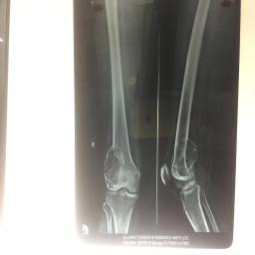

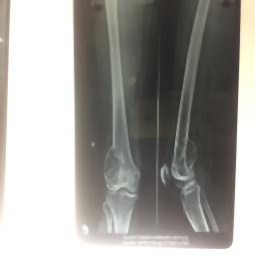

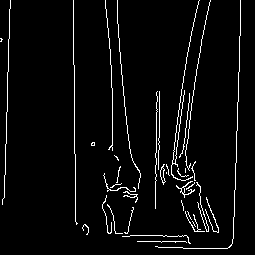


img (20).jpg


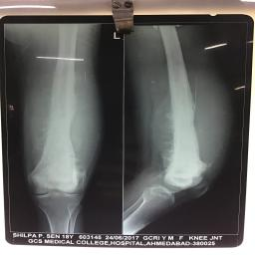

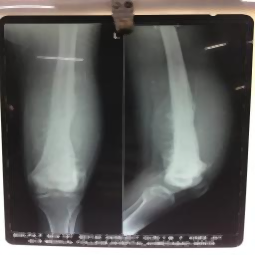

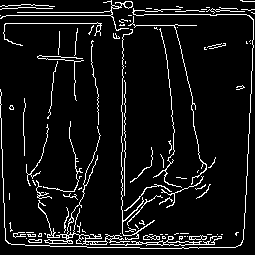


img (202).jpg


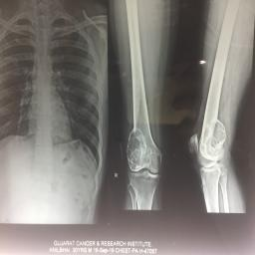

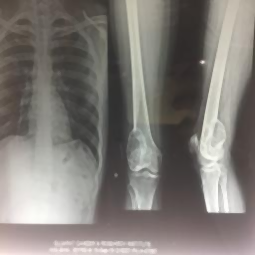

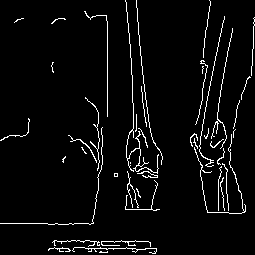


img (205).jpg


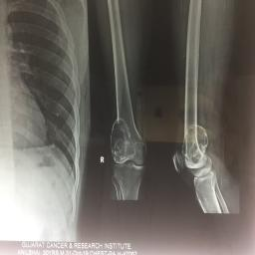

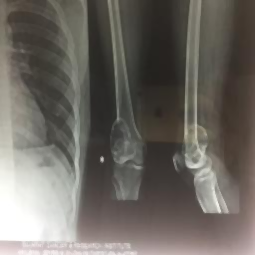

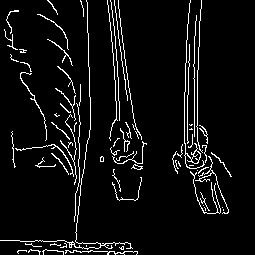


img (192).jpg


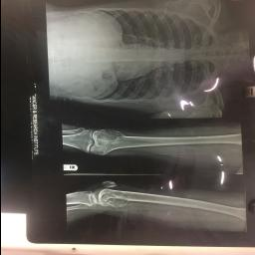

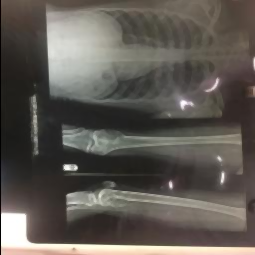

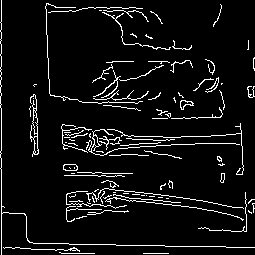


img (199).jpg


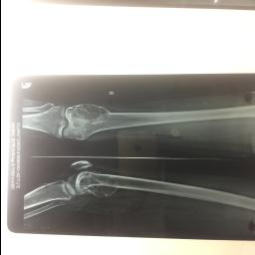

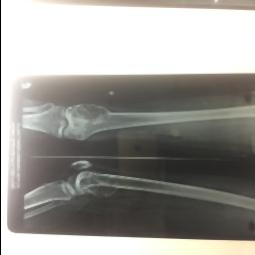

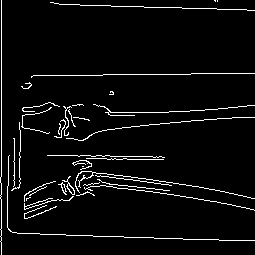


img (2).jpg


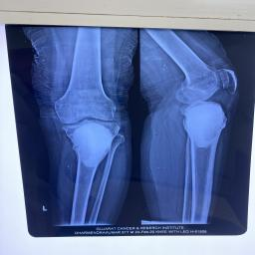

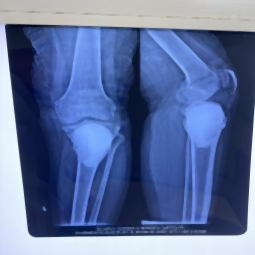

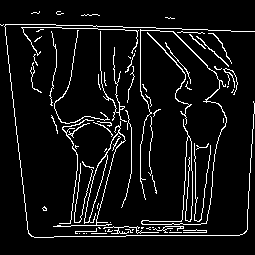


img (19).jpg


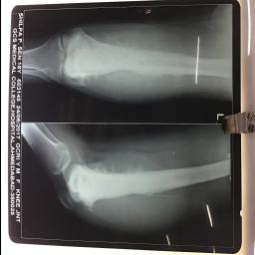

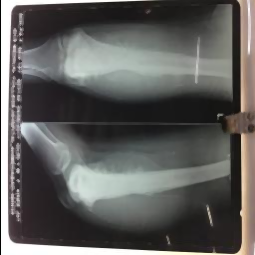

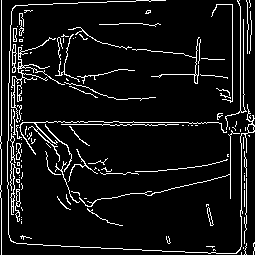


img (198).jpg


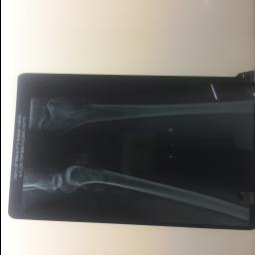

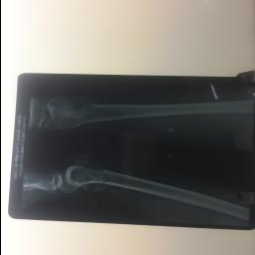

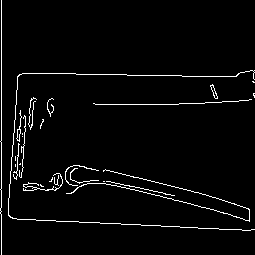


img (195).jpg


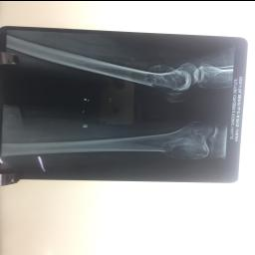

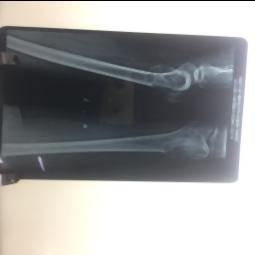

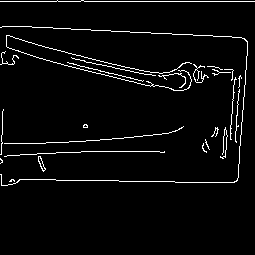


img (203).jpg


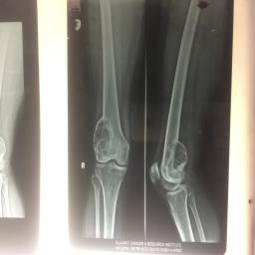

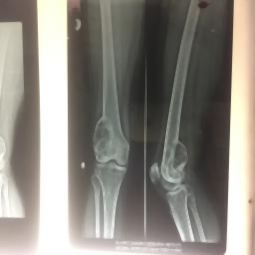

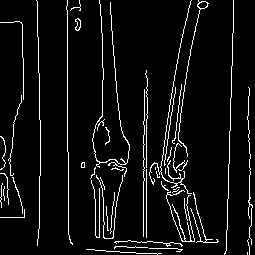


img (196).jpg


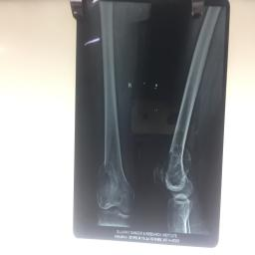

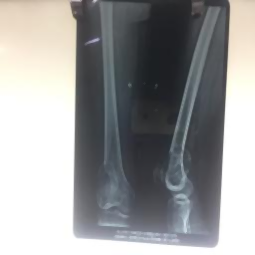

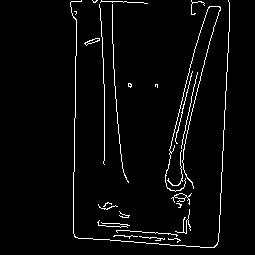


img (194).jpg


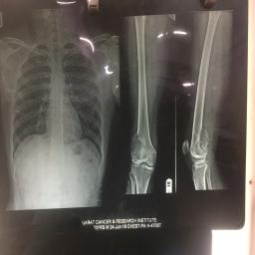

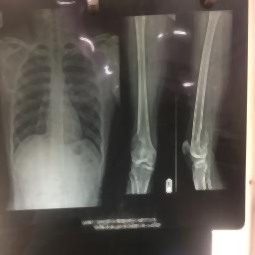

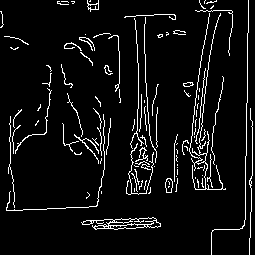


img (197).jpg


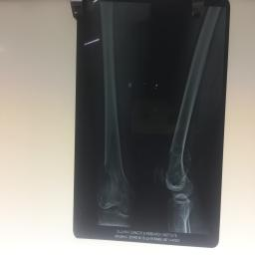

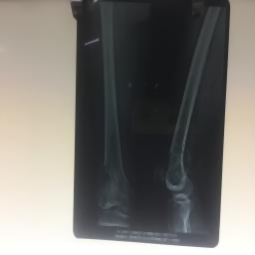

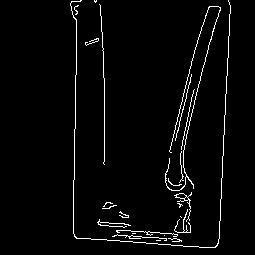


img (191).jpg


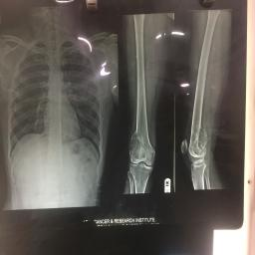

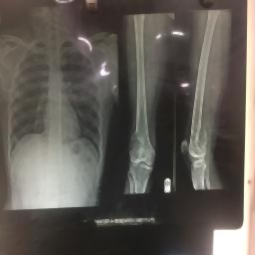

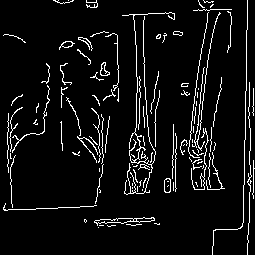


img (193).jpg


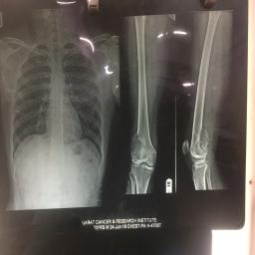

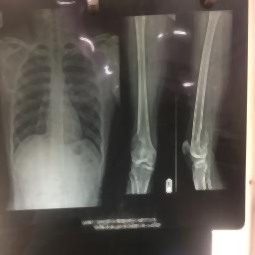

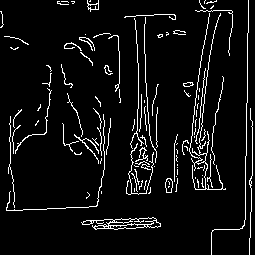


img (204).jpg


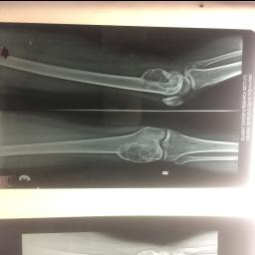

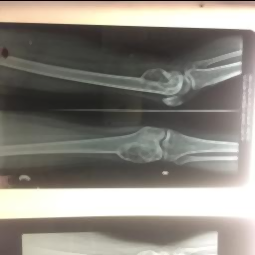

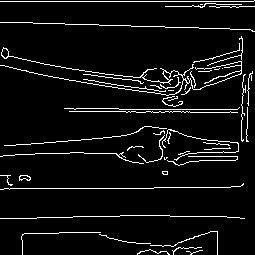


img (201).jpg


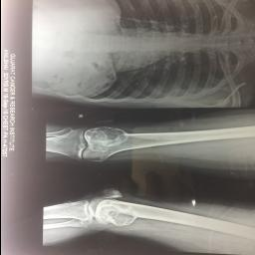

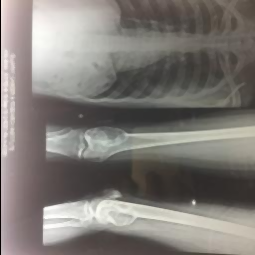

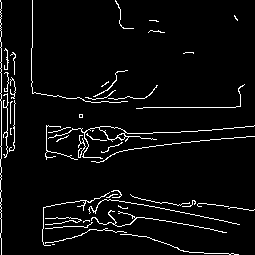


img (1).jpg


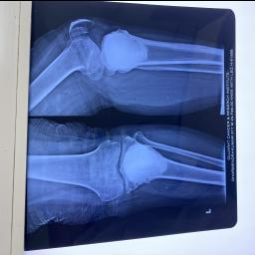

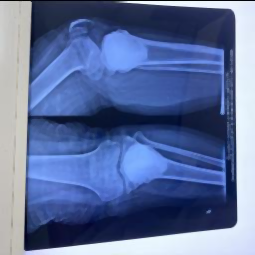

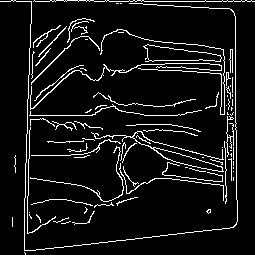


img (21).jpg


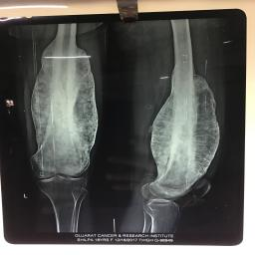

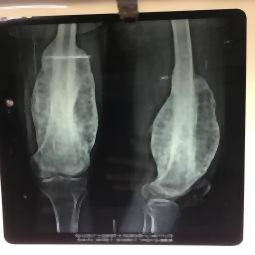

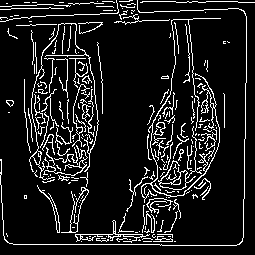


img (210).jpg


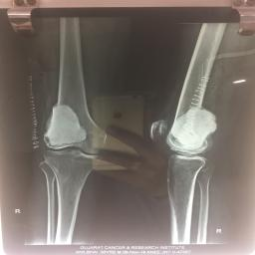

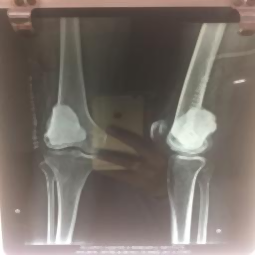

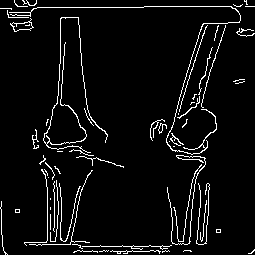


img (206).jpg


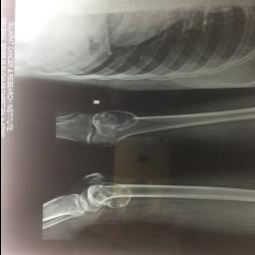

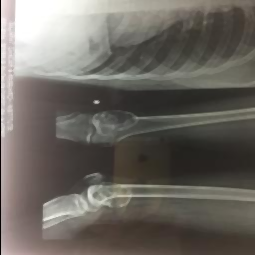

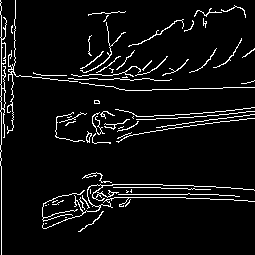


img (215).jpg


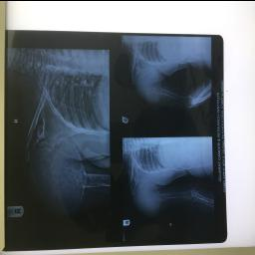

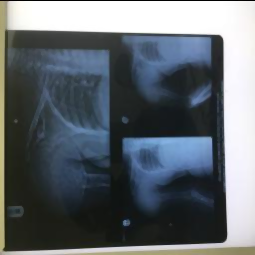

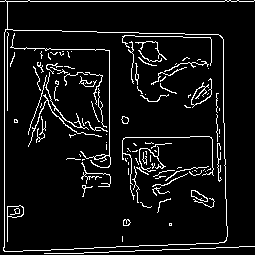


img (216).jpg


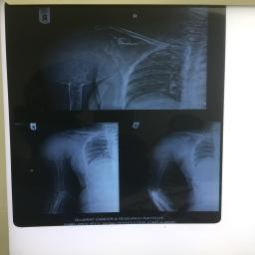

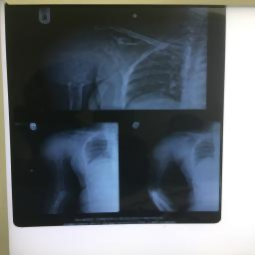

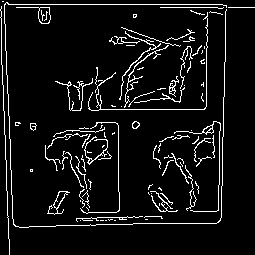


img (24).jpg


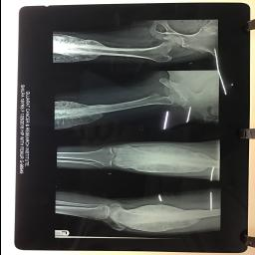

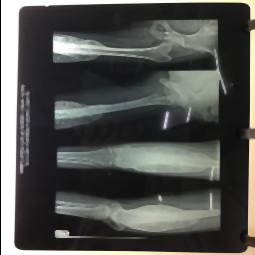

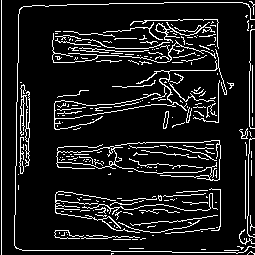


img (212).jpg


In [ ]:
try:
  file_list=os.listdir(r"/content/drive/MyDrive/Bone Cancer/Dataset - 1/train/Cancer")
  for i in file_list:
    img_original_cancerous = cv2.imread("/content/drive/MyDrive/Bone Cancer/Dataset - 1/train/Cancer/"+i)
    img_original_cancerous = cv2.resize(img_original_cancerous, (255, 255))
    img_cancerous = cv2.medianBlur(img_original_cancerous, 3)

    sigma = 0.3
    median = np.median(img_cancerous)
    lower = int(max(0, (1.0 - sigma) * median))
    upper = int(min(255, (1.0 + sigma) * median))
    auto_canny_cancerous = cv2.Canny(img_cancerous, lower, upper)
    print(i)
    cv2_imshow(img_original_cancerous)
    cv2_imshow(img_cancerous)
    cv2_imshow(auto_canny_cancerous)
    print()
    cv2.waitKey(0)
    cv2.destroyAllWindows()
except TypeError:
  pass

# Feature Extraction


In [ ]:
  model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 80.9MB/s]


In [ ]:
# from torch.nn.modules.pooling import AvgPool2d
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        # Extract VGG-16 Feature Layers
        self.features = list(model.features)
        self.features = nn.Sequential(*self.features)
        # Extract VGG-16 Max Pooling Layer
        # self.pooling = nn.MaxPool2d(1)  # checking
        self.pooling = nn.MaxPool2d(1)
        # Convert the image into one-dimensional vector
        self.flatten = nn.Flatten()
        # Extract the first part of fully-connected layer from VGG16
        self.fc = model.classifier[0]

    def forward(self, x):
        # It will take the input 'x' until it returns the feature vector called 'out'
        out = self.features(x)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out


new_model = FeatureExtractor(model)

# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)

In [ ]:

# Transform the image, so it becomes readable with the model
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(512),
    transforms.Resize(255),
    transforms.ToTensor()
])

# Will contain the feature
features = []
y = []

# file_list = os.listdir(r"/content/drive/MyDrive/CIP - SEM 6/Bone Cancer X-Ray From Email")
file_list = os.listdir(r"/content/drive/MyDrive/Bone Cancer/Dataset - 1/valid")
# file_list = os.listdir(r"/content/drive/MyDrive/CIP - SEM 6/Data Augmentation")
# print(file_list)
for i in tqdm(file_list):
    # print(i[0])
    if i[0] == 'C':
        y.append(1)
    else:
        y.append(0)
    # img_original = cv2.imread("/content/drive/MyDrive/CIP - SEM 6/Bone Cancer X-Ray From Email/" + i)
    img_original = cv2.imread("/content/drive/MyDrive/Bone Cancer/Dataset - 1/valid/" + i)
    # img_original = cv2.imread("/content/drive/MyDrive/CIP - SEM 6/Data Augmentation/" + i)
    # Resize the image
    img = cv2.resize(img_original, (255, 255))

    # Filtering the Image
    img_filtered = cv2.medianBlur(img, 3)

    # Segmenting the Image
    sigma = 0.3
    median = np.median(img_filtered)
    lower = int(max(0, (1.0 - sigma) * median))
    upper = int(min(255, (1.0 + sigma) * median))
    auto_canny = cv2.Canny(img_filtered, lower, upper)

    # Changing the colorscale
    # img = cv2.cvtColor(auto_canny, cv2.COLOR_GRAY2RGB)

    # img = cv2.cvtColor(img_filtered, cv2.COLOR_GRAY2RGB)
    img = img_filtered
    # Transform the image
    img = transform(img)

    # Reshape the image. PyTorch model reads 4-dimensional tensor [batch_size, channels, width, height]
    img = img.reshape(1, 3, 255, 255)
    img = img.to(device)

    # We only extract features, so we don't need gradient
    with torch.no_grad():
        # Extract the feature from the image
        feature = new_model(img)

    # Convert to NumPy Array, Reshape it, and save it to features variable
    features.append(feature.cpu().detach().numpy().reshape(-1))

features = np.array(features)

# Save features into a csv file
np.savetxt('/content/drive/MyDrive/Bone Cancer/Dataset - 1/features_using_new_dataset2.csv', features, delimiter=',')

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [ ]:
y = np.array(y)
y[5] =1
print(y)
print(features.shape)
print(new_model)

[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(100, 4096)
FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stri

# CM


In [ ]:
plt.rc('font', size=14)         # controls default text sizes
plt.rc('axes', titlesize=14)    # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=14)   # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Classification

In [ ]:
# Load the dataset
def load_dataset(filename):
    data = read_csv(filename, header=None)
    dataset = data.values
    X = dataset[:, :]
    return X


# Function for feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k=5)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs


# Load the dataset
X = load_dataset('/content/drive/MyDrive/Bone Cancer/Dataset - 1/features_using_new_dataset2.csv')

In [ ]:
def classification(model, name):
    scores = {}

    unique_classes = np.unique(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=30)
    X_train_fs, X_test_fs = select_features(X_train, y_train, X_test)

    model = model()
    model.fit(X_train_fs, y_train)

    y_pred = model.predict(X_test_fs)

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    false_positive_rate = fp / (fp + tn)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    pr, re, _ = precision_recall_curve(y_test, y_pred)

    scores = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Specificity": specificity,
        "False Positive Rate": false_positive_rate,
        "F1-score": f1_score(y_test, y_pred),
        "RMSE": rmse,
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc,
        "pr": pr,
        "re": re
    }

    print("Accuracy:", scores["Accuracy"])
    print("\nRecall:", scores["Recall"])
    print("\nSpecificity:", scores["Specificity"])
    print("\nPrecision:", scores["Precision"])
    print("\nFalse postive rate:", scores["False Positive Rate"])
    print("\nF1-score:", scores["F1-score"])
    print("\nRMSE:", scores["RMSE"])
    print("\nClassification Report:\n\n", classification_report(y_test, y_pred))

    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten() / np.sum(cm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]

    labels = np.asarray(labels).reshape(2, 2)

    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='gray')

    # ax.set_title('Confusion Matrix\n')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Healthy', 'Cancerous'])
    ax.yaxis.set_ticklabels(['Healthy', 'Cancerous'])

    plt.savefig('/content/drive/MyDrive/Bone Cancer/Dataset - 1/confusion_matrix2_'+ name + '.pdf', bbox_inches='tight')
    plt.savefig('/content/drive/MyDrive/Bone Cancer/Dataset - 1/confusion_matrix2_'+ name + '.png', dpi = 1000, bbox_inches='tight')
    plt.show()

    del X_train, X_test, y_train, y_test
    return scores

## SVC

Accuracy: 0.9696969696969697

Recall: 1.0

Specificity: 0.9642857142857143

Precision: 0.8333333333333334

False postive rate: 0.03571428571428571

F1-score: 0.9090909090909091

RMSE: 0.17407765595569785

Classification Report:

               precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.83      1.00      0.91         5

    accuracy                           0.97        33
   macro avg       0.92      0.98      0.95        33
weighted avg       0.97      0.97      0.97        33



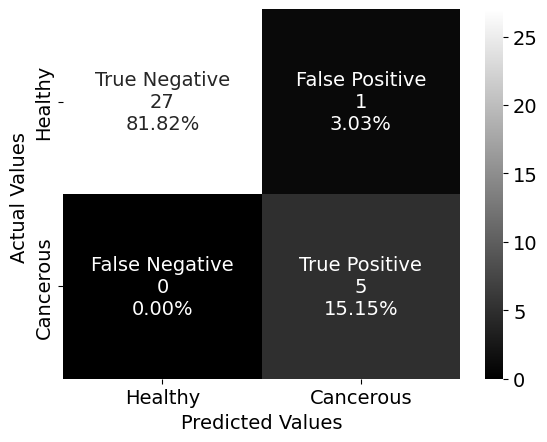

In [ ]:
svm_result = classification(SVC, "svc")

CM FOR SVC

In [ ]:
# svm_result = classification(SVC, "svc")

## Logistic Regression

Accuracy: 0.9393939393939394

Recall: 0.8

Specificity: 0.9642857142857143

Precision: 0.8

False postive rate: 0.03571428571428571

F1-score: 0.8000000000000002

RMSE: 0.24618298195866548

Classification Report:

               precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.80      0.80      0.80         5

    accuracy                           0.94        33
   macro avg       0.88      0.88      0.88        33
weighted avg       0.94      0.94      0.94        33



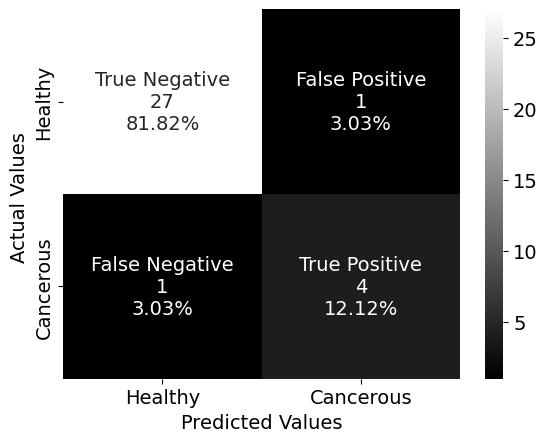

In [ ]:
lr_result = classification(LogisticRegression, "lr")

## Random Forest

Accuracy: 0.9696969696969697

Recall: 1.0

Specificity: 0.9642857142857143

Precision: 0.8333333333333334

False postive rate: 0.03571428571428571

F1-score: 0.9090909090909091

RMSE: 0.17407765595569785

Classification Report:

               precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.83      1.00      0.91         5

    accuracy                           0.97        33
   macro avg       0.92      0.98      0.95        33
weighted avg       0.97      0.97      0.97        33



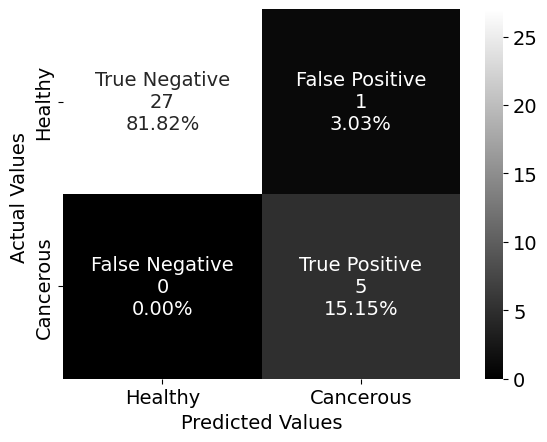

In [ ]:
rf_result = classification(RandomForestClassifier, "rf")

## KNN

Accuracy: 0.9393939393939394

Recall: 0.8

Specificity: 0.9642857142857143

Precision: 0.8

False postive rate: 0.03571428571428571

F1-score: 0.8000000000000002

RMSE: 0.24618298195866548

Classification Report:

               precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.80      0.80      0.80         5

    accuracy                           0.94        33
   macro avg       0.88      0.88      0.88        33
weighted avg       0.94      0.94      0.94        33



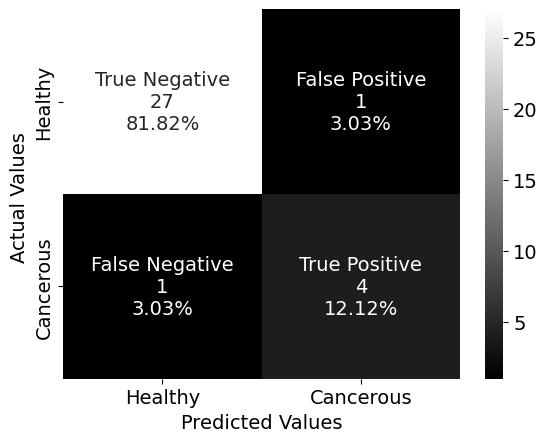

In [ ]:
knn_result = classification(KNeighborsClassifier, "knn")

## Decision Tree

Accuracy: 0.9393939393939394

Recall: 0.8

Specificity: 0.9642857142857143

Precision: 0.8

False postive rate: 0.03571428571428571

F1-score: 0.8000000000000002

RMSE: 0.24618298195866548

Classification Report:

               precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.80      0.80      0.80         5

    accuracy                           0.94        33
   macro avg       0.88      0.88      0.88        33
weighted avg       0.94      0.94      0.94        33



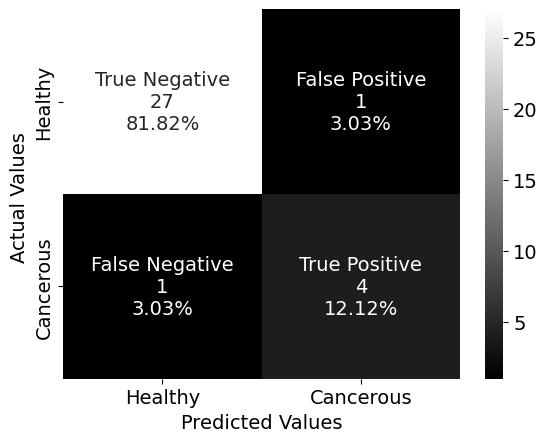

In [ ]:
dt_result = classification(DecisionTreeClassifier, "dt")

In [ ]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("/content/drive/MyDrive/Bone Cancer/Model/keras_model.h5", compile=False)

# Load the labels
class_names = open("/content/drive/MyDrive/Bone Cancer/Model/labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open("/content/drive/MyDrive/Bone Cancer/Dataset - 2/valid/Cancer/img (5).jpg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)


1/1 [==============================] - 4s 4s/step
Class: Cancer
Confidence Score: 0.9999684
